In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import random
import numpy as np
import argparse
import torch.nn.functional as F
import math
from typing import List, Tuple, Union
import warnings
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
          ):

        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim,
                out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class ConvKAN(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int or tuple = 3,
        stride: int or tuple = 1,
        padding: int or tuple = 0,
        dilation: int or tuple = 1,
        groups: int = 1,
        padding_mode: str = "zeros",
        bias: bool = True,
        grid_size: int = 5,
        spline_order: int = 3,
        scale_noise: float = 0.1,
        scale_base: float = 1.0,
        scale_spline: float = 1.0,
        enable_standalone_scale_spline: bool = True,
        base_activation: torch.nn.Module = torch.nn.SiLU,
        grid_eps: float = 0.02,
        grid_range: tuple = (-1, 1),
    ):
       
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _pair(padding)
        self.dilation = _pair(dilation)
        self.groups = groups
        self.padding_mode = padding_mode

        self._in_dim = (
            (in_channels // groups) * self.kernel_size[0] * self.kernel_size[1]
        )
        self._reversed_padding_repeated_twice = tuple(
            x for x in reversed(self.padding) for _ in range(2)
        )

        if not bias:
            # warn the user that bias is not used
            warnings.warn("Bias is not used in ConvKAN layer", UserWarning)

        if in_channels % groups != 0:
            raise ValueError("in_channels must be divisible by groups")
        if out_channels % groups != 0:
            raise ValueError("out_channels must be divisible by groups")

        self.kan_layer = FastKANLayer(self._in_dim, out_channels)

    def forward(self, x):
        if self.padding_mode != "zeros":
            x = F.pad(x, self._reversed_padding_repeated_twice, mode=self.padding_mode)
            padding = (0, 0)  # Reset padding because we already applied it
        else:
            padding = self.padding

        x_unf = F.unfold(
            x,
            kernel_size=self.kernel_size,
            padding=padding,
            stride=self.stride,
            dilation=self.dilation,
        )

        batch_size, channels_and_elem, n_patches = x_unf.shape

        # Ensuring group separation is maintained in the input
        x_unf = (
            x_unf.permute(0, 2, 1)  # [B, H_out * W_out, channels * elems]
            .reshape(
                batch_size * n_patches, self.groups, channels_and_elem // self.groups
            )  # [B * H_out * W_out, groups, out_channels // groups]
            .permute(1, 0, 2)
        )  # [groups, B * H_out * W_out, out_channels // groups]

        output = self.kan_layer(
            x_unf
        )  # [groups, B * H_out * W_out, out_channels // groups]
        output = (
            output.permute(1, 0, 2).reshape(batch_size, n_patches, -1).permute(0, 2, 1)
        )

        # Compute output dimensions
        output_height = (
            x.shape[2]
            + 2 * padding[0]
            - self.dilation[0] * (self.kernel_size[0] - 1)
            - 1
        ) // self.stride[0] + 1
        output_width = (
            x.shape[3]
            + 2 * padding[1]
            - self.dilation[1] * (self.kernel_size[1] - 1)
            - 1
        ) // self.stride[1] + 1

        # Reshape output to the expected output format
        output = output.view(
            x.shape[0],  # batch size
            self.out_channels,  # total output channels
            output_height,
            output_width,
        )

        return output


def _pair(x):
    if isinstance(x, (int, float)):
        return x, x
    return x

    
class BSplineFunction(nn.Module):
    def __init__(self, grid_min: float = -2.,
        grid_max: float = 2., degree: int = 3, num_basis: int = 8):
        super(BSplineFunction, self).__init__()
        self.degree = degree
        self.num_basis = num_basis
        self.knots = torch.linspace(grid_min, grid_max, num_basis + degree + 1)  # Uniform knots

    def basis_function(self, i, k, t):
        if k == 0:
            return ((self.knots[i] <= t) & (t < self.knots[i + 1])).float()
        else:
            left_num = (t - self.knots[i]) * self.basis_function(i, k - 1, t)
            left_den = self.knots[i + k] - self.knots[i]
            left = left_num / left_den if left_den != 0 else 0

            right_num = (self.knots[i + k + 1] - t) * self.basis_function(i + 1, k - 1, t)
            right_den = self.knots[i + k + 1] - self.knots[i + 1]
            right = right_num / right_den if right_den != 0 else 0

            return left + right 
    
    def forward(self, x):
        x = x.squeeze()  # Assuming x is of shape (B, 1)
        basis_functions = torch.stack([self.basis_function(i, self.degree, x) for i in range(self.num_basis)], dim=-1)
        return basis_functions
    
class SplineConv2D(nn.Conv2d):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: Union[int, Tuple[int, int]] = 3,
                 stride: Union[int, Tuple[int, int]] = 1, 
                 padding: Union[int, Tuple[int, int]] = 0, 
                 dilation: Union[int, Tuple[int, int]] = 1,
                 groups: int = 1, 
                 bias: bool = True, 
                 init_scale: float = 0.1, 
                 padding_mode: str = "zeros", 
                 **kw
                 ) -> None:
        self.init_scale = init_scale
        super().__init__(in_channels, 
                         out_channels, 
                         kernel_size, 
                         stride, 
                         padding, 
                         dilation, 
                         groups, 
                         bias, 
                         padding_mode, 
                         **kw
                         )

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)
        if self.bias is not None:
            nn.init.zeros_(self.bias)


class FastKANConvLayer(nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: Union[int, Tuple[int, int]] = 3,
                 stride: Union[int, Tuple[int, int]] = 1, 
                 padding: Union[int, Tuple[int, int]] = 0, 
                 dilation: Union[int, Tuple[int, int]] = 1,
                 groups: int = 1, 
                 bias: bool = True, 
                 grid_min: float = -2., 
                 grid_max: float = 2.,
                 num_grids: int = 4, 
                 use_base_update: bool = True, 
                 base_activation = F.silu,
                 spline_weight_init_scale: float = 0.1, 
                 padding_mode: str = "zeros",
                 ) -> None:
        
        super().__init__()
        self.rbf = BSplineFunction(grid_min, grid_max, 3, num_grids)

        self.spline_conv = SplineConv2D(in_channels * num_grids, 
                                        out_channels, 
                                        kernel_size,
                                        stride, 
                                        padding, 
                                        dilation, 
                                        groups, 
                                        bias,
                                        spline_weight_init_scale, 
                                        padding_mode)
        
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_conv = nn.Conv2d(in_channels, 
                                       out_channels, 
                                       kernel_size, 
                                       stride, 
                                       padding, 
                                       dilation, 
                                       groups, 
                                       bias, 
                                       padding_mode)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x_rbf = self.rbf(x.view(batch_size, channels, -1)).view(batch_size, channels, height, width, -1)
        x_rbf = x_rbf.permute(0, 4, 1, 2, 3).contiguous().view(batch_size, -1, height, width)
        
        # Apply spline convolution
        ret = self.spline_conv(x_rbf)
        
        if self.use_base_update:
            base = self.base_conv(self.base_activation(x))
            ret = ret + base
        
        return ret


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResEmoteNetKAN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ResEmoteNetKAN, self).__init__()
        # Initial layers with gradual channel increase
        self.conv1 = ConvKAN(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = FastKANConvLayer(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = FastKANConvLayer(64, 128, kernel_size=3, padding=1)  # Reduced from 128
        self.bn3 = nn.BatchNorm2d(128)
        
        # SE blocks after each major block
        self.se1 = SEBlock(128)
        self.se2 = SEBlock(256)
        self.se3 = SEBlock(512)
        
        # Modified residual blocks with smoother transitions
        self.res_block1 = ResidualBlock(128, 256, stride=2)
        self.res_block2 = ResidualBlock(256, 512, stride=2)
        self.res_block3 = ResidualBlock(512, 1024, stride=2)  # Reduced from 1024
        
        # Global pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Modified KAN layers with batch norm and smoother transitions
        self.kan_block1 = nn.Sequential(
            FastKANLayer(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.kan_block2 = nn.Sequential(
            FastKANLayer(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.kan_block3 = nn.Sequential(
            FastKANLayer(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Final classification layer with reduced complexity
        self.classifier = FastKANLayer(128, 7)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, SplineConv2D)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial convolutions with activation and pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.se1(x)
        x = F.max_pool2d(x, 2)
        
        # Residual blocks with SE attention
        x = self.res_block1(x)
        x = self.se2(x)
        
        x = self.res_block2(x)
        x = self.se3(x)
        
        x = self.res_block3(x)
        
        # Global pooling and flatten
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        
        # KAN blocks with batch norm and dropout
        x = self.kan_block1(x)
        x = self.kan_block2(x)
        x = self.kan_block3(x)
        
        # Final classification
        x = self.classifier(x)
        
        return x

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/train',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/test',  
    transform=test_transform
)

BATCH_SIZE = 16

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Initialize model, criterion, and optimizer
model = ResEmoteNetKAN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Training parameters
num_epochs = 80
patience = 15
best_val_acc = 0
patience_counter = 0
epoch_counter = 0

# History tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{train_loss/train_total:.4f}',
            'acc': f'{100.*train_correct/train_total:.2f}%'
        })
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, 'ResEmoteNetKAN_model.pth')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs.')
        
    if patience_counter >= patience:
        print('Early stopping triggered.')
        break
    
    epoch_counter += 1

# Save final results
num_epochs_completed = len(history['train_loss'])  # Menggunakan panjang aktual dari history
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_completed + 1),
    'Train Loss': history['train_loss'],
    'Val Loss': history['val_loss'],
    'Train Acc': history['train_acc'],
    'Val Acc': history['val_acc']
})
results_df.to_csv('training_history.csv', index=False)

Using cuda device
Training set size: 28709
Validation set size: 7178


Validation: 100%|██████████| 449/449 [00:21<00:00, 20.85it/s]



Epoch 1:
Train Loss: 1.8399, Train Acc: 0.2247
Val Loss: 1.8316, Val Acc: 0.2272


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.45it/s]



Epoch 2:
Train Loss: 1.8331, Train Acc: 0.2286
Val Loss: 1.8247, Val Acc: 0.2024
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.68it/s]



Epoch 3:
Train Loss: 1.8337, Train Acc: 0.2276
Val Loss: 1.8437, Val Acc: 0.2297


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.43it/s]



Epoch 4:
Train Loss: 1.8387, Train Acc: 0.2217
Val Loss: 1.8439, Val Acc: 0.1995
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.09it/s]



Epoch 5:
Train Loss: 1.8254, Train Acc: 0.2371
Val Loss: 1.7965, Val Acc: 0.2774


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.89it/s]



Epoch 6:
Train Loss: 1.6954, Train Acc: 0.3211
Val Loss: 1.5786, Val Acc: 0.3905


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.32it/s]



Epoch 7:
Train Loss: 1.6018, Train Acc: 0.3655
Val Loss: 1.5126, Val Acc: 0.3983


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.66it/s]



Epoch 8:
Train Loss: 1.5428, Train Acc: 0.3852
Val Loss: 1.5072, Val Acc: 0.4136


Validation: 100%|██████████| 449/449 [00:21<00:00, 20.68it/s]



Epoch 9:
Train Loss: 1.5018, Train Acc: 0.4019
Val Loss: 1.4576, Val Acc: 0.4374


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.71it/s]



Epoch 10:
Train Loss: 1.4615, Train Acc: 0.4176
Val Loss: 1.4910, Val Acc: 0.4510


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.81it/s]



Epoch 11:
Train Loss: 1.4499, Train Acc: 0.4283
Val Loss: 1.5061, Val Acc: 0.4342
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.71it/s]



Epoch 12:
Train Loss: 1.4046, Train Acc: 0.4491
Val Loss: 1.3825, Val Acc: 0.4533


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.54it/s]



Epoch 13:
Train Loss: 1.3691, Train Acc: 0.4602
Val Loss: 1.3237, Val Acc: 0.4820


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.20it/s]



Epoch 14:
Train Loss: 1.3387, Train Acc: 0.4753
Val Loss: 1.3178, Val Acc: 0.4937


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.77it/s]



Epoch 15:
Train Loss: 1.3003, Train Acc: 0.4955
Val Loss: 1.3104, Val Acc: 0.4866
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.32it/s]



Epoch 16:
Train Loss: 1.2799, Train Acc: 0.5013
Val Loss: 1.2865, Val Acc: 0.5082


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.09it/s]



Epoch 17:
Train Loss: 1.2627, Train Acc: 0.5110
Val Loss: 1.2192, Val Acc: 0.5223


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.74it/s]



Epoch 18:
Train Loss: 1.2285, Train Acc: 0.5238
Val Loss: 1.2889, Val Acc: 0.5148
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.89it/s]



Epoch 19:
Train Loss: 1.2015, Train Acc: 0.5384
Val Loss: 1.2325, Val Acc: 0.5291


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.44it/s]



Epoch 20:
Train Loss: 1.1816, Train Acc: 0.5451
Val Loss: 1.2119, Val Acc: 0.5442


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.37it/s]



Epoch 21:
Train Loss: 1.1624, Train Acc: 0.5561
Val Loss: 1.2437, Val Acc: 0.5302
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.31it/s]



Epoch 22:
Train Loss: 1.1341, Train Acc: 0.5675
Val Loss: 1.2020, Val Acc: 0.5607


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.38it/s]



Epoch 23:
Train Loss: 1.1148, Train Acc: 0.5763
Val Loss: 1.2432, Val Acc: 0.5439
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.19it/s]



Epoch 24:
Train Loss: 1.0941, Train Acc: 0.5891
Val Loss: 1.1920, Val Acc: 0.5623


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.62it/s]



Epoch 25:
Train Loss: 1.0583, Train Acc: 0.6065
Val Loss: 1.2037, Val Acc: 0.5603
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.87it/s]



Epoch 26:
Train Loss: 1.0439, Train Acc: 0.6126
Val Loss: 1.2428, Val Acc: 0.5658


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.92it/s]



Epoch 27:
Train Loss: 1.0154, Train Acc: 0.6287
Val Loss: 1.2084, Val Acc: 0.5492
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.18it/s]



Epoch 28:
Train Loss: 0.9872, Train Acc: 0.6364
Val Loss: 1.2018, Val Acc: 0.5836


Validation: 100%|██████████| 449/449 [00:11<00:00, 39.65it/s]



Epoch 29:
Train Loss: 0.9580, Train Acc: 0.6505
Val Loss: 1.2238, Val Acc: 0.5839


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.84it/s]



Epoch 30:
Train Loss: 0.9350, Train Acc: 0.6603
Val Loss: 1.1918, Val Acc: 0.5892


Validation: 100%|██████████| 449/449 [00:11<00:00, 38.66it/s]



Epoch 31:
Train Loss: 0.9019, Train Acc: 0.6738
Val Loss: 1.2120, Val Acc: 0.5929


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.05it/s]



Epoch 32:
Train Loss: 0.8763, Train Acc: 0.6841
Val Loss: 1.2305, Val Acc: 0.5921
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.15it/s]



Epoch 33:
Train Loss: 0.8482, Train Acc: 0.6969
Val Loss: 1.3104, Val Acc: 0.5880
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.44it/s]



Epoch 34:
Train Loss: 0.8142, Train Acc: 0.7103
Val Loss: 1.2880, Val Acc: 0.5910
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 38.28it/s]



Epoch 35:
Train Loss: 0.7864, Train Acc: 0.7219
Val Loss: 1.2713, Val Acc: 0.5885
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.82it/s]



Epoch 36:
Train Loss: 0.7559, Train Acc: 0.7322
Val Loss: 1.2031, Val Acc: 0.6064


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.04it/s]



Epoch 37:
Train Loss: 0.7247, Train Acc: 0.7476
Val Loss: 1.2935, Val Acc: 0.5995
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.82it/s]



Epoch 38:
Train Loss: 0.6946, Train Acc: 0.7598
Val Loss: 1.3743, Val Acc: 0.5967
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.35it/s]



Epoch 39:
Train Loss: 0.6686, Train Acc: 0.7697
Val Loss: 1.3392, Val Acc: 0.5982
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.77it/s]



Epoch 40:
Train Loss: 0.6357, Train Acc: 0.7792
Val Loss: 1.3381, Val Acc: 0.6063
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.88it/s]



Epoch 41:
Train Loss: 0.6143, Train Acc: 0.7911
Val Loss: 1.3002, Val Acc: 0.6025
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.39it/s]



Epoch 42:
Train Loss: 0.5783, Train Acc: 0.8041
Val Loss: 1.3742, Val Acc: 0.6062
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.23it/s]



Epoch 43:
Train Loss: 0.5476, Train Acc: 0.8175
Val Loss: 1.4464, Val Acc: 0.5974
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:12<00:00, 36.09it/s]



Epoch 44:
Train Loss: 0.5211, Train Acc: 0.8270
Val Loss: 1.4640, Val Acc: 0.6048
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.83it/s]



Epoch 45:
Train Loss: 0.4931, Train Acc: 0.8381
Val Loss: 1.4298, Val Acc: 0.6133


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.67it/s]



Epoch 46:
Train Loss: 0.4705, Train Acc: 0.8470
Val Loss: 1.4662, Val Acc: 0.6028
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.93it/s]



Epoch 47:
Train Loss: 0.4406, Train Acc: 0.8560
Val Loss: 1.5633, Val Acc: 0.6041
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.86it/s]



Epoch 48:
Train Loss: 0.4208, Train Acc: 0.8656
Val Loss: 1.4734, Val Acc: 0.6095
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.26it/s]



Epoch 49:
Train Loss: 0.3959, Train Acc: 0.8726
Val Loss: 1.5743, Val Acc: 0.6096
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.96it/s]



Epoch 50:
Train Loss: 0.3774, Train Acc: 0.8789
Val Loss: 1.6256, Val Acc: 0.6135


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.28it/s]



Epoch 51:
Train Loss: 0.3591, Train Acc: 0.8878
Val Loss: 1.5383, Val Acc: 0.6087
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.12it/s]



Epoch 52:
Train Loss: 0.3426, Train Acc: 0.8920
Val Loss: 1.6070, Val Acc: 0.6069
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:18<00:00, 24.05it/s]



Epoch 53:
Train Loss: 0.3244, Train Acc: 0.8987
Val Loss: 1.6795, Val Acc: 0.6102
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:16<00:00, 27.58it/s]



Epoch 54:
Train Loss: 0.2993, Train Acc: 0.9065
Val Loss: 1.7732, Val Acc: 0.5832
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:13<00:00, 33.13it/s]



Epoch 55:
Train Loss: 0.2906, Train Acc: 0.9111
Val Loss: 1.8129, Val Acc: 0.6024
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.11it/s]



Epoch 56:
Train Loss: 0.2665, Train Acc: 0.9202
Val Loss: 1.7410, Val Acc: 0.6081
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.61it/s]



Epoch 57:
Train Loss: 0.2525, Train Acc: 0.9239
Val Loss: 1.8344, Val Acc: 0.5939
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.39it/s]



Epoch 58:
Train Loss: 0.2446, Train Acc: 0.9264
Val Loss: 1.8373, Val Acc: 0.6123
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.18it/s]



Epoch 59:
Train Loss: 0.2325, Train Acc: 0.9289
Val Loss: 1.7971, Val Acc: 0.6162


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.58it/s]



Epoch 60:
Train Loss: 0.2264, Train Acc: 0.9324
Val Loss: 1.8373, Val Acc: 0.6069
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.52it/s]



Epoch 61:
Train Loss: 0.2109, Train Acc: 0.9354
Val Loss: 1.8587, Val Acc: 0.6087
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:23<00:00, 19.45it/s]



Epoch 62:
Train Loss: 0.2094, Train Acc: 0.9378
Val Loss: 1.8844, Val Acc: 0.6123
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:23<00:00, 19.19it/s]



Epoch 63:
Train Loss: 0.2063, Train Acc: 0.9376
Val Loss: 1.7928, Val Acc: 0.6128
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 40.96it/s]



Epoch 64:
Train Loss: 0.1905, Train Acc: 0.9432
Val Loss: 1.9295, Val Acc: 0.6142
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 37.69it/s]



Epoch 65:
Train Loss: 0.1856, Train Acc: 0.9464
Val Loss: 1.9923, Val Acc: 0.6195


Validation: 100%|██████████| 449/449 [00:12<00:00, 37.14it/s]



Epoch 66:
Train Loss: 0.1805, Train Acc: 0.9481
Val Loss: 1.8989, Val Acc: 0.6025
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.39it/s]



Epoch 67:
Train Loss: 0.1726, Train Acc: 0.9485
Val Loss: 1.9724, Val Acc: 0.6147
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:16<00:00, 27.46it/s]



Epoch 68:
Train Loss: 0.1651, Train Acc: 0.9518
Val Loss: 2.0262, Val Acc: 0.5979
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:12<00:00, 36.92it/s]



Epoch 69:
Train Loss: 0.1595, Train Acc: 0.9531
Val Loss: 2.0548, Val Acc: 0.5875
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.04it/s]



Epoch 70:
Train Loss: 0.1529, Train Acc: 0.9539
Val Loss: 1.9687, Val Acc: 0.6037
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 38.72it/s]



Epoch 71:
Train Loss: 0.1466, Train Acc: 0.9580
Val Loss: 1.9991, Val Acc: 0.6020
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.85it/s]



Epoch 72:
Train Loss: 0.1430, Train Acc: 0.9573
Val Loss: 1.9843, Val Acc: 0.6123
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:12<00:00, 35.79it/s]



Epoch 73:
Train Loss: 0.1403, Train Acc: 0.9588
Val Loss: 1.9355, Val Acc: 0.6102
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.35it/s]



Epoch 74:
Train Loss: 0.1369, Train Acc: 0.9602
Val Loss: 2.1568, Val Acc: 0.5995
No improvement for 9 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.08it/s]



Epoch 75:
Train Loss: 0.1379, Train Acc: 0.9595
Val Loss: 1.9732, Val Acc: 0.6202


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.00it/s]



Epoch 76:
Train Loss: 0.1389, Train Acc: 0.9595
Val Loss: 1.9105, Val Acc: 0.6081
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.12it/s]



Epoch 77:
Train Loss: 0.1329, Train Acc: 0.9622
Val Loss: 2.0081, Val Acc: 0.6096
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.24it/s]



Epoch 78:
Train Loss: 0.1233, Train Acc: 0.9633
Val Loss: 2.0702, Val Acc: 0.6098
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.16it/s]



Epoch 79:
Train Loss: 0.1185, Train Acc: 0.9637
Val Loss: 2.2697, Val Acc: 0.5952
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.34it/s]


Epoch 80:
Train Loss: 0.1149, Train Acc: 0.9667
Val Loss: 2.1576, Val Acc: 0.5985
No improvement for 5 epochs.


In [3]:
import warnings
warnings.filterwarnings('ignore')

def convert_pth_to_pt(model_path, output_path='model.pt'):
    """
    Convert .pth checkpoint to .pt format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .pt model file
    Returns:
        str: Path to saved .pt model
    """
    try:
        # Initialize model
        model = ResEmoteNetKAN()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Set model to eval mode
        model.eval()
        
        # Save model in .pt format
        torch.save(model, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_pth_to_ptl(model_path, output_path='model.ptl'):
    """
    Convert .pth checkpoint to .ptl (PyTorch Lightning) format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .ptl model file
    Returns:
        str: Path to saved .ptl model
    """
    try:
        # Initialize model
        model = ResEmoteNetKAN()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Create new state dict with Lightning compatible format
        new_state_dict = {
            'state_dict': checkpoint['model_state_dict'],
            'epoch': checkpoint.get('epoch', 0),
            'global_step': 0,
            'pytorch-lightning_version': '2.0.0',
            'callbacks': {},
            'optimizer_states': [checkpoint.get('optimizer_state_dict', {})],
            'lr_schedulers': [],
            'hparams_name': 'ResEmoteNet',
            'hyper_parameters': {
                'learning_rate': 0.001,
                'batch_size': 16,
                'num_classes': 7
            }
        }
        
        # Save in Lightning format
        torch.save(new_state_dict, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_all_formats(model_path, base_output_name='model'):
    """
    Convert .pth model to both .pt and .ptl formats
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        base_output_name (str): Base name for output files
    Returns:
        tuple: Paths to saved .pt and .ptl models
    """
    pt_path = f"{base_output_name}.pt"
    ptl_path = f"{base_output_name}.ptl"
    
    pt_result = convert_pth_to_pt(model_path, pt_path)
    ptl_result = convert_pth_to_ptl(model_path, ptl_path)
    
    return pt_result, ptl_result



def plot_training_curves(history):
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training Analysis', fontsize=16, y=1.05)

    # Loss curves
    axes[0,0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0,0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0,0].set_title('Loss Curves')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Accuracy curves
    axes[0,1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[0,1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[0,1].set_title('Accuracy Curves')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Learning curves (Training vs Validation Gap)
    train_val_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1,0].plot(train_val_gap, label='Train-Val Accuracy Gap', color='purple')
    axes[1,0].set_title('Overfitting Analysis')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy Gap')
    axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Learning Rate if available
    if 'lr' in history:
        axes[1,1].plot(history['lr'], label='Learning Rate', color='green')
        axes[1,1].set_title('Learning Rate Schedule')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Learning Rate')
        axes[1,1].set_yscale('log')
        axes[1,1].legend()
        axes[1,1].grid(True)
    else:
        fig.delaxes(axes[1,1])  # Better way to remove subplot

    plt.tight_layout()
    plt.savefig('training_curves.png', bbox_inches='tight', dpi=300)
    plt.show()

def evaluate_model(model, val_loader, device, class_names):

    model.eval()
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")

def plot_sample_predictions(model, val_loader, device, class_names, num_samples=5):

    model.eval()
    
    try:
        fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
        
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            
            for i in range(min(num_samples, len(inputs))):
                # Plot image
                img = inputs[i].cpu().permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                img = img.clip(0, 1)
                
                axes[0, i].imshow(img)
                axes[0, i].axis('off')
                true_label = class_names[labels[i]]
                pred_label = class_names[outputs[i].argmax()]
                axes[0, i].set_title(f'True: {true_label}\nPred: {pred_label}',
                                   color='green' if true_label == pred_label else 'red')
                
                # Plot probability distribution
                probs = probabilities[i].cpu().numpy()
                axes[1, i].bar(range(len(class_names)), probs)
                axes[1, i].set_xticks(range(len(class_names)))
                axes[1, i].set_xticklabels(class_names, rotation=45)
                axes[1, i].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig('sample_predictions.png', bbox_inches='tight', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")

def print_parameter_details(model):
    """
    Print model parameter details and total trainable parameters.
    
    Args:
        model (torch.nn.Module): The model to analyze
    """
    try:
        total_params = 0
        print("\nModel Parameter Details:")
        print("-" * 50)
        for name, parameter in model.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                total_params += params
                print(f"{name:<30} {params:>10,d}")
        print("-" * 50)
        print(f"Total trainable parameters: {total_params:,}")
        
    except Exception as e:
        print(f"Error analyzing parameters: {str(e)}")


Model Parameter Details:
--------------------------------------------------
conv1.kan_layer.layernorm.weight         27
conv1.kan_layer.layernorm.bias         27
conv1.kan_layer.spline_linear.weight      6,912
conv1.kan_layer.base_linear.weight        864
conv1.kan_layer.base_linear.bias         32
bn1.weight                             32
bn1.bias                               32
conv2.spline_conv.weight           73,728
conv2.spline_conv.bias                 64
conv2.base_conv.weight             18,432
conv2.base_conv.bias                   64
bn2.weight                             64
bn2.bias                               64
conv3.spline_conv.weight          294,912
conv3.spline_conv.bias                128
conv3.base_conv.weight             73,728
conv3.base_conv.bias                  128
bn3.weight                            128
bn3.bias                              128
se1.fc.0.weight                     1,024
se1.fc.2.weight                     1,024
se2.fc.0.weight            

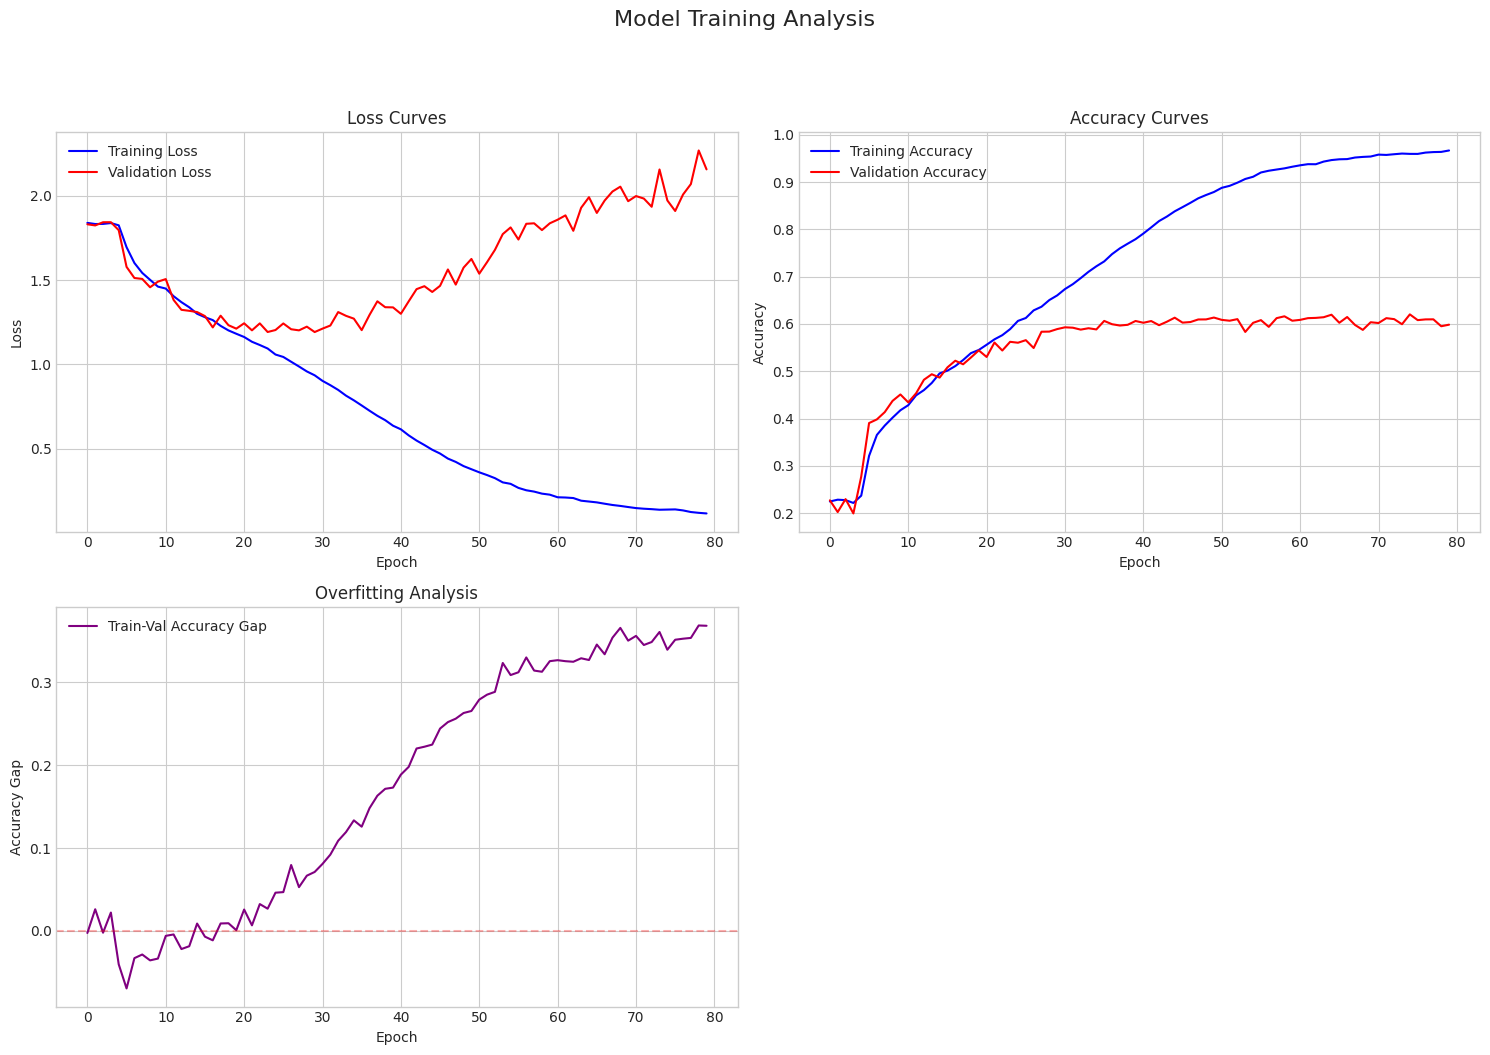

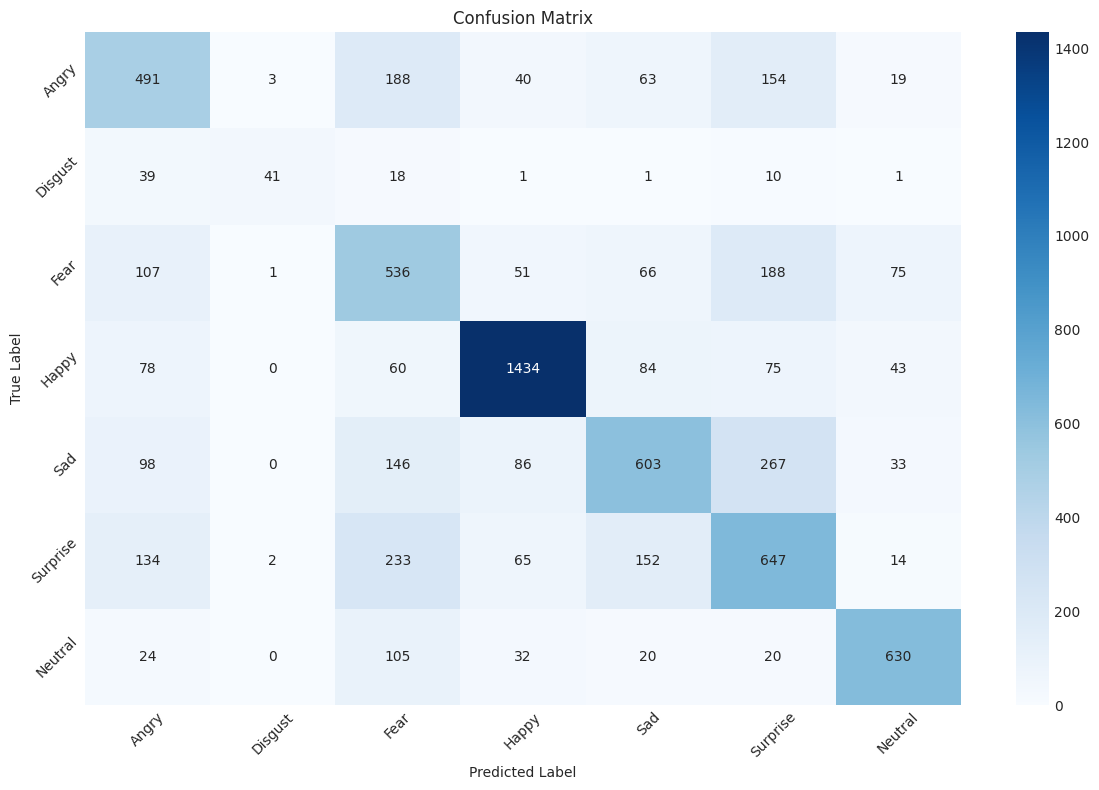


Classification Report:
              precision    recall  f1-score   support

       Angry       0.51      0.51      0.51       958
     Disgust       0.87      0.37      0.52       111
        Fear       0.42      0.52      0.46      1024
       Happy       0.84      0.81      0.82      1774
         Sad       0.61      0.49      0.54      1233
    Surprise       0.48      0.52      0.50      1247
     Neutral       0.77      0.76      0.77       831

    accuracy                           0.61      7178
   macro avg       0.64      0.57      0.59      7178
weighted avg       0.62      0.61      0.61      7178



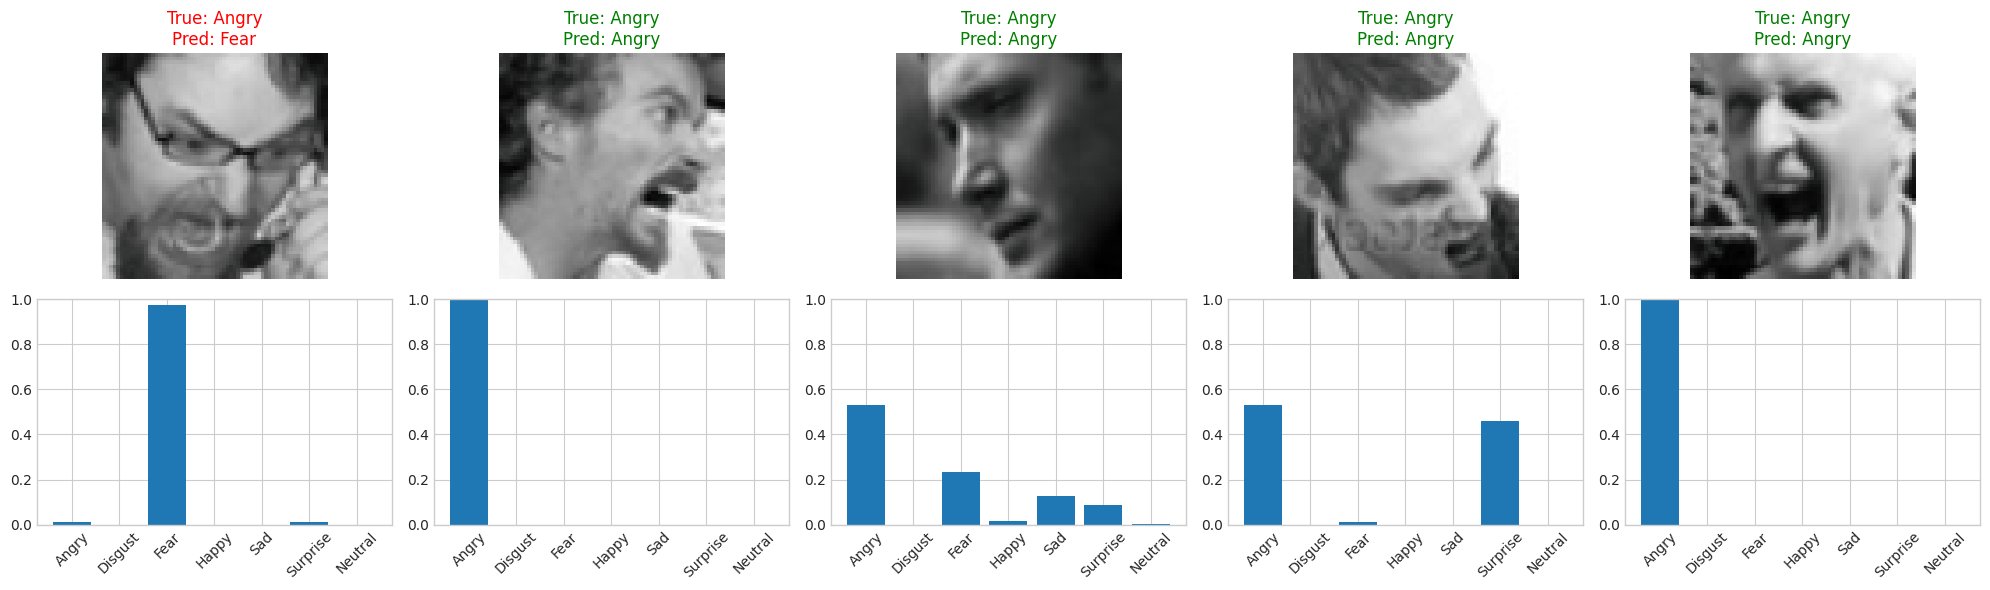

In [4]:
print_parameter_details(model)

pt_path, ptl_path = convert_all_formats('ResEmoteNetKAN_model.pth', 'ResEmoteNetKAN')

plot_training_curves(history)

# Definisikan nama kelas sesuai dengan dataset FER2013
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Evaluasi model dan tampilkan confusion matrix
evaluate_model(model, val_loader, device, class_names)

# Tampilkan contoh prediksi
plot_sample_predictions(model, val_loader, device, class_names)